<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
#загружаем необходимые библиотеки
import pandas as pd

from matplotlib.pyplot import plot as plt

from numpy.random import RandomState

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_0 = pd.read_csv('/Users/amirk/Downloads/geo_data_0.csv')
    data_1 = pd.read_csv('/Users/amirk/Downloads/geo_data_1.csv')
    data_2 = pd.read_csv('/Users/amirk/Downloads/geo_data_2.csv')

In [3]:
#напишем функцию для знакомства с датасетами:
def explore_data(data):
    display(data.head())
    print()
    print(data.info())
    print()
    print(data.describe())
    print()
    print('Количество полных дубликатов в данных равно ', data.duplicated().sum())
    print('Количество дубликатов в столбце "id" равно ', data['id'].duplicated().sum())
    print(data[data['id'].duplicated(keep=False)].sort_values(by='id'))
    data.hist(grid=True, figsize=(10,7))

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.34

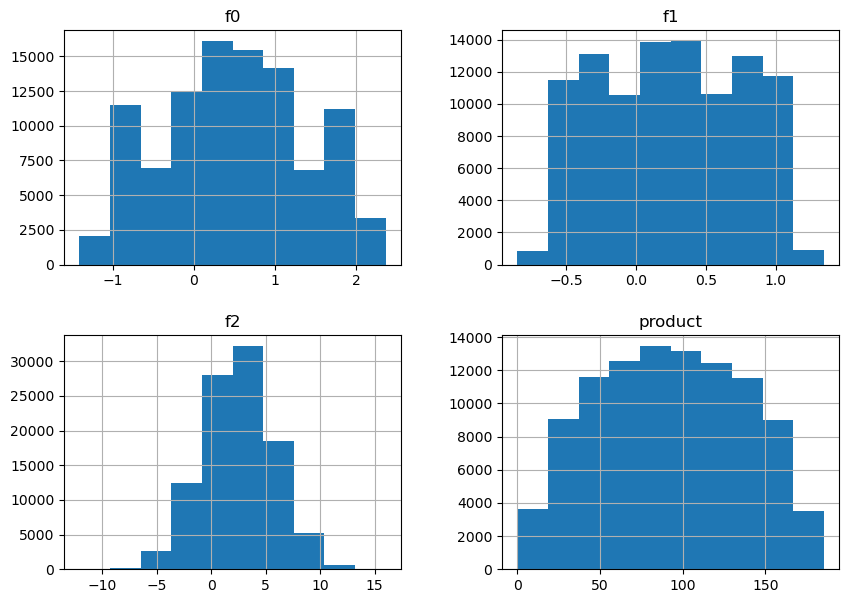

In [4]:
explore_data(data_0)

В датасете `data_0` пропусков и полных дубликатов нет, выбросов в данных нет. Выявлено 10 дубликатов в столбце **id**, данные в них различаются, вероятно ошибка при сборе данных. 

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.73

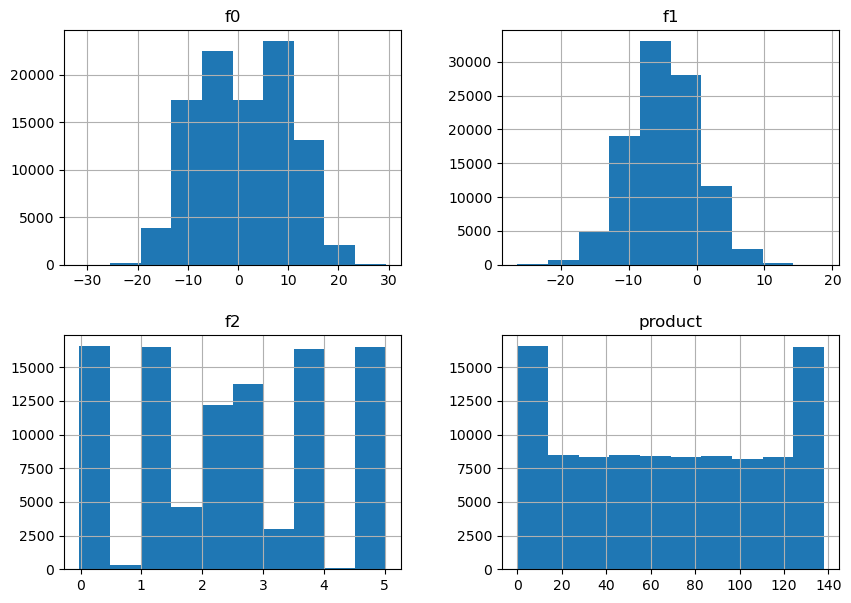

In [5]:
explore_data(data_1)

В датасете `data_1` также нет пропусков и дубликатов, выбросов в данных нет.

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.84

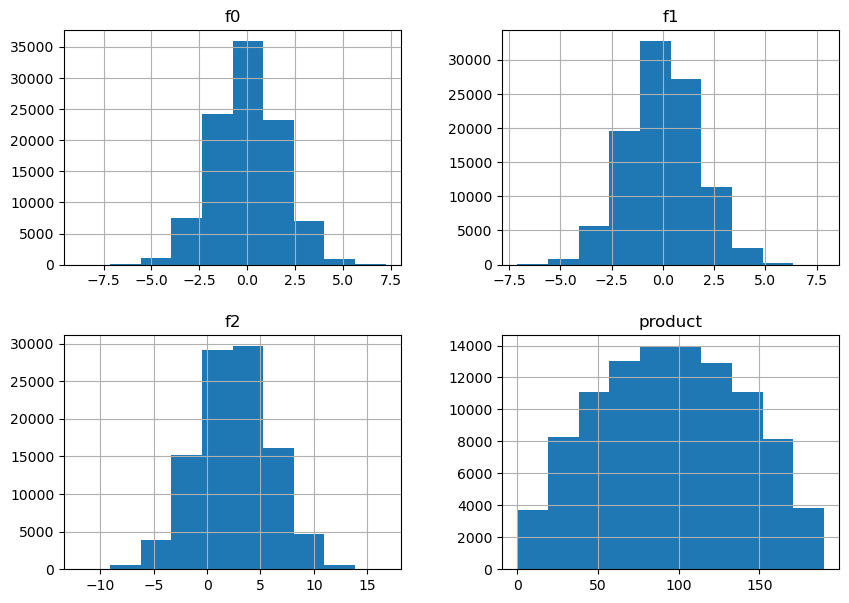

In [6]:
explore_data(data_2)

В датасете `data_2` также нет пропусков и дубликатов, выбросов в данных нет.

Предобработка данных
- в каждом датасете выявлены единичные дубликаты в столбце `id`. Удалим данные строки, т.к. они критически не повлияют на выборку в целом.
- в данных присутсвует столбец `id`, который не несет в себе информации необходимой для построения моделей. Удалим его.   
- данные количественные - семплирование проводить не нужно
- для загрузки данных в модель линейной регрессии и получения коэффициентов (возможно понадобятся в будущем), характеризующих значимость признаков, необходимо выполнить масштабирование признаков.

In [7]:
#создадим функцию для предобработки данных
def prep_data(data):
    data_temp = data.drop_duplicates(subset='id').drop('id', axis=1)
    X = data_temp.drop('product', axis=1)
    y = data_temp['product']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test 


In [8]:
data_0_samp = prep_data(data_0)
data_1_samp = prep_data(data_1)
data_2_samp = prep_data(data_2)

## Обучение и проверка модели

In [9]:
def best_model(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    params = {}
    grid_model = GridSearchCV(model, 
                              params, 
                              cv=5, 
                              scoring='neg_root_mean_squared_error', 
                              error_score='raise', 
                              n_jobs=-1, 
                              verbose=1)
    grid_model.fit(X_train, y_train)
    y_predict = grid_model.predict(X_test)
    print(f'Средний запас сырья на месторождении в данном регионе {y_predict.mean():.3f} тыс. баррелей')
    print('Значение RMSE = ', mean_squared_error(y_test, y_predict, squared=False))
    return y_predict 

In [10]:
y_predict0 = best_model(data_0_samp[0], data_0_samp[1], data_0_samp[2], data_0_samp[3])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Средний запас сырья на месторождении в данном регионе 92.681 тыс. баррелей
Значение RMSE =  37.59580657262362


In [11]:
y_predict1 = best_model(data_1_samp[0], data_1_samp[1], data_1_samp[2], data_1_samp[3])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Средний запас сырья на месторождении в данном регионе 69.314 тыс. баррелей
Значение RMSE =  0.8944711936820191


In [12]:
y_predict2 = best_model(data_2_samp[0], data_2_samp[1], data_2_samp[2], data_2_samp[3])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Средний запас сырья на месторождении в данном регионе 94.938 тыс. баррелей
Значение RMSE =  40.04908749269798


**Промежуточные выводы**
- в регионе 1 и 3 предполагаемые запасы сырья на одной скважине схожи, 92.681 и 94.938 тыс. баррелей соответсвенно. При этом значения RMSE очень высокие 37.596 и 40.049 тыс. баррелей соответсвенно. Модель плохо предсказывает запас сырья.
- в регионе 2 предполагаемые запасы сырья на одной скважине 69.314 тыс. баррелей, что меньше, чем 1 и 3 регионе, однако RMSE равно 0.894 тыс. баррелей. Модель очень хорошо предсказывает данные.
- данные различия могут повлиять на потенциальную прибыль. Проверим какая тактика будет более выигрышной, разработка скажин с меньшим количеством запасов сырья, но зато стабильно одинаково, либо регионы с большим разбросом запасов на скважине, но с большим средниим запасом.

## Подготовка к расчёту прибыли

In [13]:
# пропишем все необходимые переменные
EXPENSE = 10_000_000_000
EXPLORE_WELL = 500
BEST_WELL = 200
PROFIT = 450000 
min_barrel_per_well = EXPENSE / BEST_WELL / PROFIT

In [14]:
print(f'Минимально количество сырья на скважине, необходимое для безубыточной добычи равно не \
        менее {min_barrel_per_well:.3f} тыс. баррелей.')

Минимально количество сырья на скважине, необходимое для безубыточной добычи равно не         менее 111.111 тыс. баррелей.


Минимальное количество сырья на скважине необходимое для безубыточной добычи гораздо выше, чем среднее количество предполагаемых запасов сырья: **111.111 тыс. баррелей** против **92.634, 69.364 и 95.12 тыс. баррелей** в 1, 2 и 3 регионеах соответсвенно. При этом, учитывая высокие значения RMSE в 1 и 3 регионах, лучшие скважины могут иметь необходимый минимальный объем сырья для безубыточной добычи.

## Расчёт прибыли и рисков 

In [15]:
#калькулятор для расчета прибыли
def calc_profit(y_predict, y_test, a):
    if a == 1:
        y_predict = pd.Series(y_predict, index=y_test.index)
        y_predict_best200 = y_predict.sort_values(ascending=False)[:200]
        y_test_best200 = y_test.loc[y_predict_best200.index]
        profit_pred = y_predict_best200.sum() * PROFIT - EXPENSE
        profit_test =  y_test_best200.sum() * PROFIT - EXPENSE
        print(f'Предполагаемая прибыль от 200 скважин с максимальным количеством сырья равна {profit_pred:.3f}')
        print(f'Реальная прибыль от спрогнозированных 200 скважин с максимальным количеством сырья равна {profit_test:.3f} (расчет на тестовых данных)')
    else:
        y_predict_best200 = y_predict.sort_values(ascending=False)[:200]
        y_test_best200 = y_test.loc[y_predict_best200.index]
        profit_pred = y_test_best200.sum() * PROFIT - EXPENSE
        return profit_pred

In [16]:
calc_profit(y_predict0, data_0_samp[3], 1)

Предполагаемая прибыль от 200 скважин с максимальным количеством сырья равна 3904656301.780
Реальная прибыль от спрогнозированных 200 скважин с максимальным количеством сырья равна 3254756682.630 (расчет на тестовых данных)


In [17]:
calc_profit(y_predict1, data_1_samp[3], 1)

Предполагаемая прибыль от 200 скважин с максимальным количеством сырья равна 2489728484.390
Реальная прибыль от спрогнозированных 200 скважин с максимальным количеством сырья равна 2415086696.682 (расчет на тестовых данных)


In [18]:
calc_profit(y_predict2, data_2_samp[3], 1)

Предполагаемая прибыль от 200 скважин с максимальным количеством сырья равна 3424530588.668
Реальная прибыль от спрогнозированных 200 скважин с максимальным количеством сырья равна 2237552315.497 (расчет на тестовых данных)


In [19]:
#калькулятор прибыли  после применения бутстрепа
def bootstrap_calc(y_predict, y_test):
    state = RandomState(123)
    values = []
    count = 0
    bootstrap_samples = 1000
    y_predict = pd.Series(y_predict, index=y_test.index)
    for i in range(bootstrap_samples):
        subsamples = y_predict.sample(EXPLORE_WELL, replace=True, random_state=state)
        values.append(calc_profit(subsamples, y_test, 0))
        if calc_profit(subsamples, y_test, 0) < 0:
            count += 1
    values = pd.Series(values)
    print(f'Средняя прогнозируемая прибыль на 200 скважинах с максимальным количеством сырья равна {int(values.mean())}, 95% доверительный интервал {int(values.quantile(q=0.025))} - {int(values.quantile(q=0.975))}. Риск убытков равен {count / bootstrap_samples:.2%}')
    return [int(values.mean()), int(values.quantile(q=0.025)), int(values.quantile(q=0.975)), format((count / bootstrap_samples), '.2%')]

In [20]:
geo1 = bootstrap_calc(y_predict0, data_0_samp[3])

Средняя прогнозируемая прибыль на 200 скважинах с максимальным количеством сырья равна 394841382, 95% доверительный интервал -131716443 - 900093498. Риск убытков равен 6.70%


In [21]:
geo2 = bootstrap_calc(y_predict1, data_1_samp[3])

Средняя прогнозируемая прибыль на 200 скважинах с максимальным количеством сырья равна 488403884, 95% доверительный интервал 79510951 - 883658384. Риск убытков равен 0.80%


In [22]:
geo3 = bootstrap_calc(y_predict2, data_2_samp[3])

Средняя прогнозируемая прибыль на 200 скважинах с максимальным количеством сырья равна 344163677, 95% доверительный интервал -209593341 - 840262477. Риск убытков равен 10.70%


In [23]:
#Соберем все в одну табличку 
final_table = pd.DataFrame(columns=['Средняя прибыль (руб.)', 'Нижняя граница 95% доверительного интервала', 'Верхняя граница 95% доверительного интервала', 'Риск убытков'])
for i in [geo1, geo2, geo3]:
    i = pd.DataFrame([i], columns=['Средняя прибыль (руб.)', 'Нижняя граница 95% доверительного интервала', 'Верхняя граница 95% доверительного интервала', 'Риск убытков'])
    final_table = pd.concat([final_table, i]) 
final_table.reset_index(inplace=True, drop=True)
final_table.rename(index={0:'geo1', 1:'geo2', 2:'geo3'}, inplace=True)
final_table.sort_values(by='Средняя прибыль (руб.)', ascending=False)

,Средняя прибыль (руб.),Нижняя граница 95% доверительного интервала,Верхняя граница 95% доверительного интервала,Риск убытков
geo2,488403884,79510951,883658384,0.80%
geo1,394841382,-131716443,900093498,6.70%
geo3,344163677,-209593341,840262477,10.70%


- в регионах 1 и 3 риск убытков составил более 2.5%, поэтому для разработки они не рассматриваются.     
    
- наибольшая средняя прибыль выявлена в регионе 2 -  488403884	руб.   

**Таким образом, лучшим регионом для разработки является регион 2.**

## Выводы

- в ходе исследования мы ознакомились с данными, выполнили подготовку данных для их загрузки в модели
- построили модель прогнозирования запаса сырья на отдельной скажине, посчитали прогнозируемый средний объем запаса сырья на 1 скважине в регионе.
   - в регионе 1 и 3 предполагаемые запасы сырья на одной скважине схожи, 92.681 и 94.938 тыс. баррелей соответсвенно. При этом значения RMSE очень высокие 37.596 и 40.049 тыс. баррелей соответсвенно.
   - в регионе 2 предполагаемые запасы сырья на одной скважине 69.314 тыс. баррелей, что меньше, чем 1 и 3 регионе, однако RMSE равно 0.894 тыс. баррелей.  
- рассчитали минимальный объем запаса сырья на скважине, требуемый для безубыточной добычи (111.111 тыс. баррелей)
- написали функцию для расчета предполагаемой прибыли от 200 скважин с максимальным количеством сырья.
- методикой бутстрепа рассчитали распределение прибыли, оценили среднюю прибыль, 95% доверительный интервал для прибыли, а также рсассчитали риск убытков. 

| Регион | Средняя прибыль (руб.) | Нижняя граница 95% доверительного интервала | Верхняя граница 95% доверительного интервала | Риск убытков |
|----|----|----|----|----|
| geo2 | 488403884 | 79510951 | 883658384 |	0.80% |
|geo1|	394841382|	-131716443|	900093498|	6.70%|
|geo3|	344163677|	-209593341|	840262477|	10.70%|
	   
      - в регионах 1 и 3 риск убытков составил более 2.5%, поэтому для разработки они не рассматриваются.     
      - наибольшая средняя прибыль выявлена в регионе 2 -  488403884	руб.
**Таким образом, лучшим регионом для разработки является регион 2.**